## Introduction

 This it the notebook  with the analysis of the Titanic dataset from Kaggle. The sinking of the Titanic is one of history's most iconic disasters and the challenge is to predict passenger survival based on factors such as gender, age, and class.
 In this project, after reviewing the approaches taken by other users, I applied data cleaning and preprocessing techniques to organize and prepare the dataset. I extracted actionable insights by analyzing patterns and relationships among features and developed a machine learning model to predict survival with a strong accuracy score. This project demonstrates the ability to handle end-to-end data workflows—from data exploration and visualization to predictive modeling—while delivering insights that translate data into real-world contexts.

## Packages

In [69]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import os
#importing input directory path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/Titanic/Titanic.sql
/kaggle/input/titanic/Titanic/train.csv
/kaggle/input/titanic/Titanic/test.csv
/kaggle/input/titanic/Titanic/gender_submission.csv


## Some functions

In [77]:
def Histogram_plotB(X_train, Y_train, N_train, X_test, Y_test, N_test, xlabel, ylabel, xrotation, color, w, fname, showgraph, title):
    plt.cla()
    plt.clf()
    
    # Creating the layout for two side-by-side charts
    fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
    plt.suptitle(title)
    
    # Bar chart for training data
    barras_train = ax[0].bar(X_train, Y_train, width=w, color=color, edgecolor='black', alpha=0.7)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title('Train Data')
    
    # Add count on the y-axis and percentage at the top of the bars (Train)
    total_train = sum(Y_train)  
    for barra in barras_train:
        # Percentage
        percentage = (barra.get_height() / N_train) * 100
        ax[0].text(
            barra.get_x() + barra.get_width() / 2,  
            barra.get_height(),  
            f"{percentage:.1f}%",  
            ha='center', 
            va='bottom', 
            fontsize=8,
        )

    # Bar chart for test data
    barras_test = ax[1].bar(X_test, Y_test, width=w, color=color, edgecolor='black', alpha=0.7)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel)
    ax[1].set_title('Test Data')
    
    # Add count on the y-axis and percentage at the top of the bars (Test)
    total_test = sum(Y_test)  
    for barra in barras_test:
        # Percentage
        percentage = (barra.get_height() / N_test) * 100
        ax[1].text(
            barra.get_x() + barra.get_width() / 2,  
            barra.get_height(),  
            f"{percentage:.1f}%",  
            ha='center', 
            va='bottom', 
            fontsize=8,
        )

    # Configure labels on the X-axis
    ax[0].set_xticks(X_train) 
    ax[1].set_xticks(X_test)  

    ax[0].set_xticklabels(X_train, rotation=xrotation)  # Define labels and rotation
    ax[1].set_xticklabels(X_test, rotation=xrotation) 
    
    # Display or save the chart
    if showgraph:
        plt.show()
    else:
        plt.savefig(fname + ".png", dpi=600)

def Histogram_plot(X, Y, xlabel, ylabel, xticks, xrotation, color, w, fname, showgraph):
    plt.cla()
    plt.clf()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Gráfico de barras
    barras = plt.bar(X, Y, width=w, color=color, edgecolor='black', alpha=0.7)

    # Adiciona valores acima das barras
    for barra in barras:
        plt.text(
            barra.get_x() + barra.get_width() / 2,  # Centro horizontal da barra
            barra.get_height(),  # Altura da barra
            f"{barra.get_height():.0f}",  # Valor da barra
            ha='center',  # Alinhamento horizontal
            va='bottom',  # Alinhamento vertical
            fontsize=8,
        )
    
    # Configura rótulos no eixo X
    plt.xticks(ticks=X, labels=xticks, rotation=xrotation)
    
    # Exibe ou salva o gráfico
    if showgraph:
        plt.show()
    else:
        plt.savefig(fname + ".png", dpi=600)


def Age_analysis(df, fname, showgraph, freq):
    # Determine the maximum and minimum ages in the dataset
    Max_age = int(np.max(df['Age']))
    Min_age = int(np.min(df['Age']))
    Age_array = np.arange(Min_age, Max_age + 10, 10)  
    
    Age_surv_count = []  
    Age_surv_X = [] 
    Age_count = []  

    for i in range(1, len(Age_array)):
        # Count the number of passengers within each age bin
        Age_count.append(len(df[(df.Age <= Age_array[i]) & (df.Age > Age_array[i-1])]))

        if Age_count[i-1] != 0:
            # Calculate survival rate for the current age bin
            Age_surv_count.append(100 * len(df[(df.Age <= Age_array[i]) & (df.Age > Age_array[i-1]) & (df.Survived == 1)]) / Age_count[i-1])
            Age_surv_X.append(Age_array[i])
        else:
            continue

    if freq:
        # Plot histogram showing frequency of passengers by age bins
        Histogram_plot(Age_surv_X, Age_count, "Age (years)", "Frequency", ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80"], 30, 'seagreen', 8, fname, showgraph)
    else:
        # Plot histogram showing survival rates by age bins
        Histogram_plot(Age_surv_X, Age_surv_count, "Age (years)", "Fraction of survivors (%)", ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80"], 30, 'seagreen', 8, fname, showgraph)

def Tickets_analysis(df, fname, showgraph, freq):
    # Analyze ticket prefixes and their correlation with survival
    tickets_str = ['Numeric', 'A/5', 'A.5.', 'A/4', 'A.4.', 'AQ', 'C ', 'PC', 'SOTON', 'WE/P', 
                   'W./C.', 'W/C.', 'PP', 'STON', 'C.A.', 'CA', 'S.O.P.', 'F.C.C.', 'SC/PARIS', 
                   'SC/Paris', 'S.W.', 'SC/AH', 'S.O.', 'S.W.']

    Tickets_surv_count = []  # List to store survival rates for each ticket prefix
    Tickets_count = []  # List to store ticket counts for each prefix

    for tc in tickets_str:
        if tc == 'Numeric':
            # Filter tickets that are completely numeric
            filtered_df = df[df['Ticket'].str.match(r'^\d+$', na=False)]
        else:
            # Filter tickets that start with the specified prefix
            filtered_df = df[df['Ticket'].str.startswith(tc, na=False)]

        
        Tickets_count.append(len(filtered_df))

        # Calculate survival rate for the current ticket prefix
        if len(filtered_df) > 0:
            survival_rate = 100 * len(filtered_df.loc[filtered_df['Survived'] == 1]) / len(filtered_df)
        else:
            survival_rate = 0 

        Tickets_surv_count.append(survival_rate)

    if freq:
        # Plot histogram showing ticket prefix frequency
        Histogram_plot(tickets_str, Tickets_count, "Ticket word", "Frequency", tickets_str, 70, 'darkorange', 0.7, fname, showgraph)
    else:
        # Plot histogram showing survival rates by ticket prefix
        Histogram_plot(tickets_str, Tickets_surv_count, "Ticket word", "Fraction of survivors(%)", tickets_str, 70, 'darkorange', 0.7, fname, showgraph)

def Cabin_analysis(df, fname, showgraph, freq):
    
    # Analyze cabin prefixes and their correlation with survival
    Cabins_str = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    Cabins_count = []  

    for cb in Cabins_str:
        # Filter cabins starting with the current prefix
        filtered_df = df[df['Cabin'].str.contains('^' + cb, na=False)]
        if freq:
            Cabins_count.append(len(filtered_df))  
        else:
            Cabins_count.append(100 * len(filtered_df.loc[filtered_df.Survived == 1]) / len(filtered_df))  # Calculate survival rate

    if freq:
        # Add count of null cabin values
        Cabins_count.append(len(df.loc[df.Cabin.isna()]))
        Cabins_str.append("Null")

        # Create a tree map visualization for cabin counts
        plt.figure(figsize=(8, 8))
        plt.title("Cabin initials count")
        labels = [f"{count}\n{frequency}" for count, frequency in zip(Cabins_str, Cabins_count)]
        squarify.plot(sizes=Cabins_count, label=labels, alpha=0.8, color=["#4B0082", "#191970", "#FF4500", "#228B22", "#DAA520", "#C71585", "#8B0000", "#2F4F4F"], text_kwargs={'color': 'white', 'fontsize': 10, 'fontname': 'Impact'})
        plt.axis("off")
    else:
        # Plot histogram showing survival rates by cabin prefix
        Histogram_plot(Cabins_str, Cabins_count, "Cabin initials", "Fraction of survivors (%)", Cabins_str, 0, 'y', 0.7, fname, showgraph)

def Embarked_analysis(df, fname, showgraph):
    # Analyze ports of embarkation and their correlation with survival
    embarked_type = ['Cherbourg', 'Queenstown', 'Southampton']
    embarked_surv_count = []  # List to store survival rates for each port

    for et in embarked_type:
        embarked_count = df.loc[df.Embarked == et]
        embarked_surv_count.append(100 * len(df.loc[(df.Embarked == et) & (df.Survived == 1)]) / len(embarked_count))

    # Plot histogram showing survival rates by port of embarkation
    Histogram_plot(embarked_type, embarked_surv_count, "Port of Embarkation", "Fraction of survivors", ["Cherbourg", "Queenstown", "Southampton"], 30, 'b', 0.7, fname, showgraph)
    return np.array([embarked_type, embarked_surv_count])


## Loading the data

In [71]:
# Loading the data
train_data = pd.read_csv("/kaggle/input/titanic/Titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/Titanic/test.csv")
full_data = pd.merge(train_data, test_data, on = test_data.keys().tolist(), how = "outer")

## EXPLORATORY DATA ANALYSIS (EDA)

Let's examine the distribution of passenger features, starting with the relationship between gender and survival probabilities in the training data.

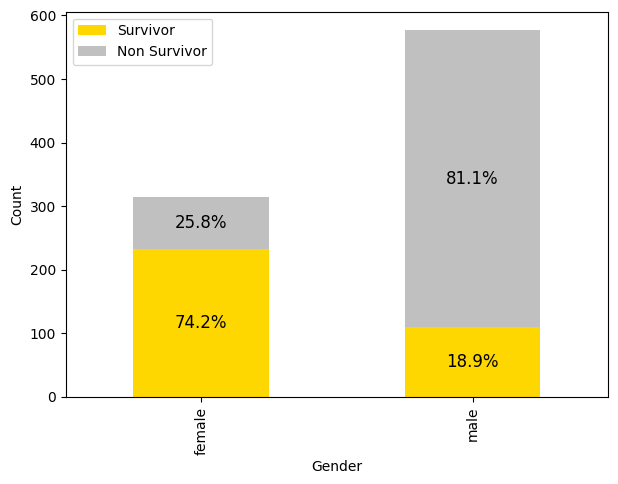

In [72]:

#Stacked bar plot

#Selecting the Sex and Survived columns
gender_surv = pd.crosstab(train_data['Sex'], train_data['Survived'])
gender_surv = gender_surv[[1, 0]]

#Plot
ax = gender_surv.plot(kind = 'bar', stacked = True, figsize = (7,5), color = ['gold', 'silver'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend([ "Survivor", "Non Survivor"])
totals = gender_surv.sum(axis=1).values

#Percentage of survivors for each gender 
for p in ax.patches:
    width = p.get_width()   
    height = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    if height > 0:  # Avoid bars with zero hights
        percentage = height / totals[int(x)] * 100
        ax.text(x, y, f'{percentage:.1f}%', ha='center', va='center', fontsize=12, color='k')


 Here we have a significant relationship: the number of male passengers is more than 1.5 times that of female passengers. Despite this disparity, the number of female survivors is more than twice the number of male survivors. Specifically, 74% of the female passengers survived, compared to just 18.9% of the male passengers. This stark contrast highlights that gender is strongly correlated with the likelihood of survival.

 Before proceeding with data cleaning, it is important to examine the counts and proportions of the features. This analysis is performed next, comparing the train and test datasets.

<Figure size 640x480 with 0 Axes>

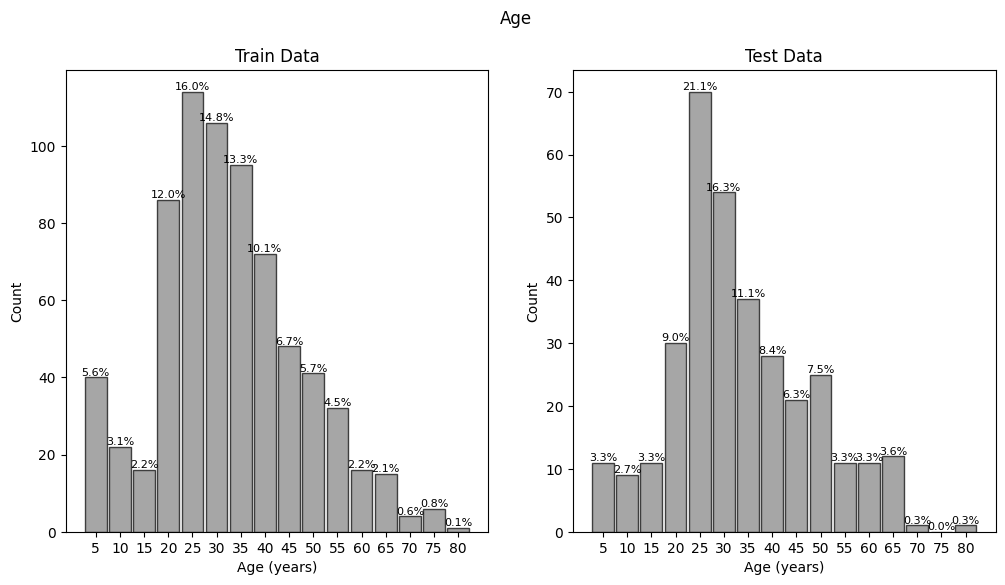

<Figure size 640x480 with 0 Axes>

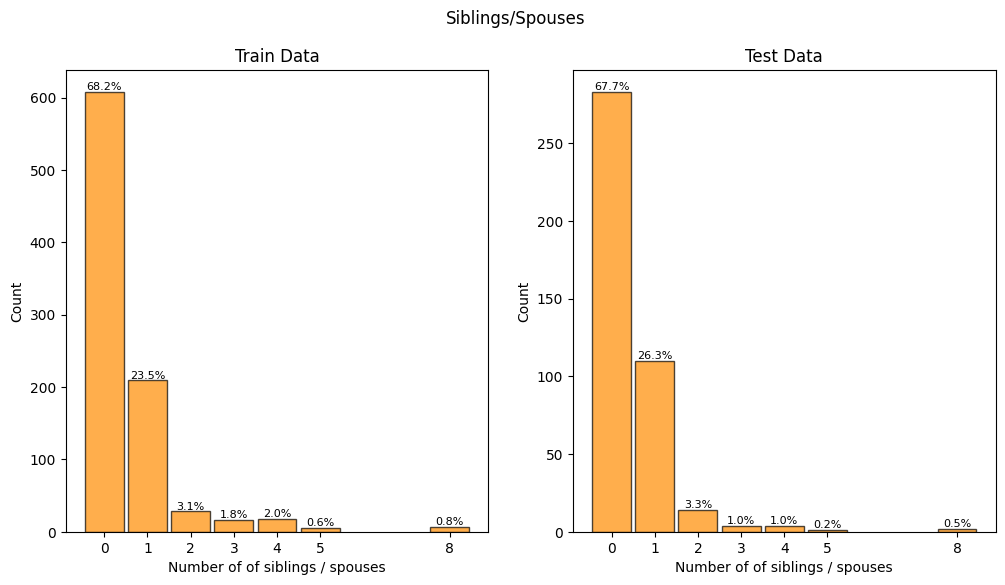

<Figure size 640x480 with 0 Axes>

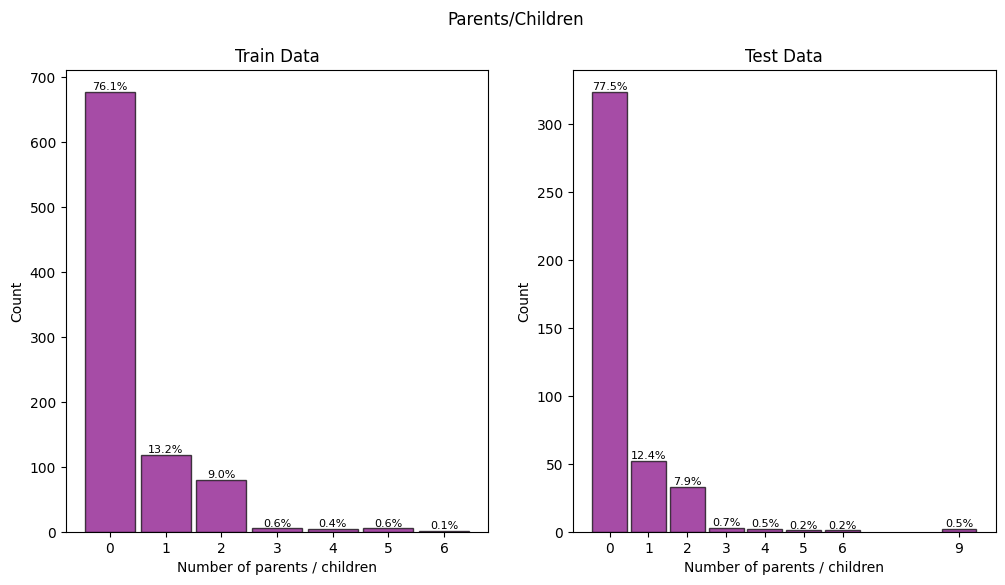

<Figure size 640x480 with 0 Axes>

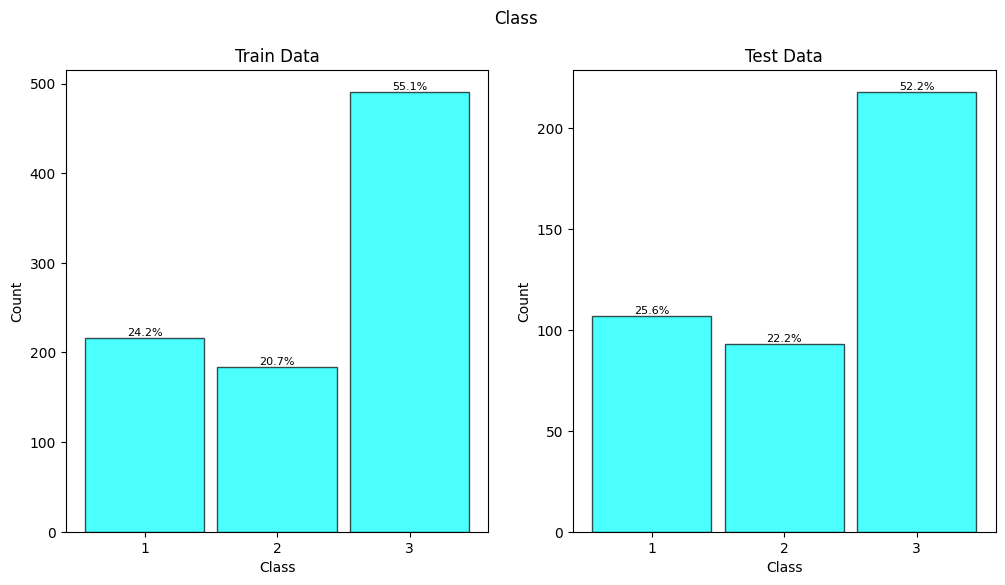

<Figure size 640x480 with 0 Axes>

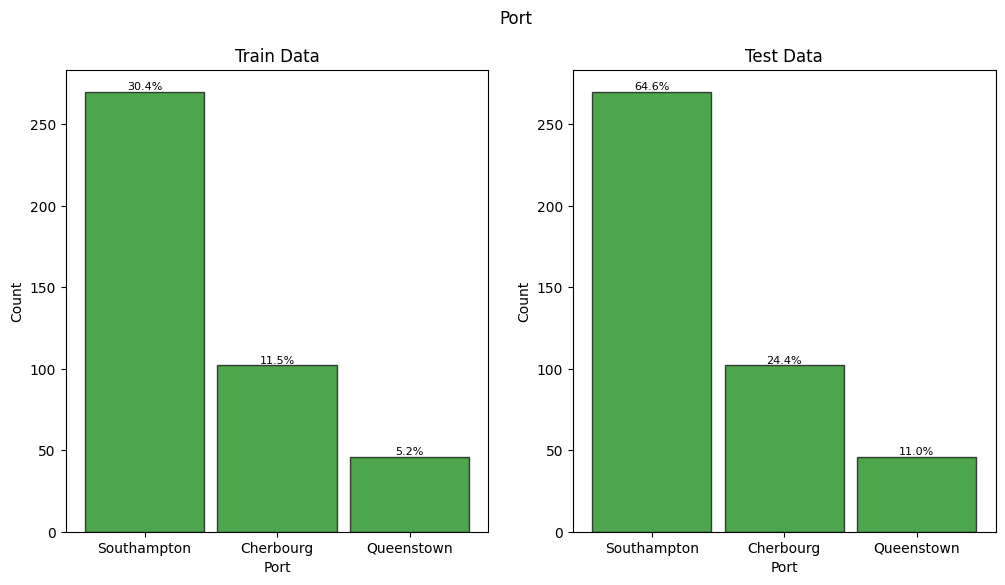

In [73]:
features = ["Sex", "Age", "SibSp", "Parch", "Pclass", "Embarked"]
title = ["Age", "Siblings/Spouses", "Parents/Children","Class", "Port" ]

#Age 

Max_age = int(np.max(train_data['Age']))
Min_age = int(np.min(train_data['Age']))
Age_bin =  np.arange(Min_age, Max_age+5, 5)
Age_hist_train = []
Age_hist_test = []
for ag in range(1,len(Age_bin)-1):
    Age_hist_train.append(len(train_data.loc[(train_data.Age>= Age_bin[ag-1])& (train_data.Age< Age_bin[ag])]))
    Age_hist_test.append(len(test_data.loc[(test_data.Age>= Age_bin[ag-1])& (test_data.Age< Age_bin[ag])]))
Age_hist_train.append(len(train_data.loc[(train_data.Age>= Age_bin[-2])& (train_data.Age<= Age_bin[-1])]))
Age_hist_test.append(len(test_data.loc[(test_data.Age>= Age_bin[-2])& (test_data.Age<= Age_bin[-1])]))

Age_xtick = ["0-4", "5-9", "10-14","15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-80"]
Histogram_plotB(Age_bin[1:] , Age_hist_train,len(train_data['Age'].dropna()), Age_bin[1:] , Age_hist_test,len(test_data['Age'].dropna()), "Age (years)", "Count",  0, "gray", (Age_bin[2] -Age_bin[1])*0.9, "", 1, "Age")

#SibSp

SibX_train = train_data['SibSp'].dropna().unique()
SibX_test = test_data['SibSp'].dropna().unique()
SibX_train.sort()
SibX_test.sort()
Sib_hist_train = []
Sib_hist_test = []
for sib in SibX_train:
    Sib_hist_train.append(len(train_data.loc[train_data.SibSp == sib ]))
for sib in SibX_test:
    Sib_hist_test.append(len(test_data.loc[test_data.SibSp == sib ]))

Histogram_plotB(SibX_train  , Sib_hist_train,len(train_data['SibSp'].dropna()), SibX_test  , Sib_hist_test,len(test_data['SibSp'].dropna()), "Number of of siblings / spouses", "Count", 0, "darkorange", 0.9, "", 1, "Siblings/Spouses")

#Parch
#dropping null values
ParchX_train = train_data['Parch'].dropna().unique()
ParchX_test = test_data['Parch'].dropna().unique()

#sort
ParchX_train.sort()
ParchX_test.sort()

Parch_hist_train = []
Parch_hist_test = []
for par in ParchX_train:
    Parch_hist_train.append(len(train_data.loc[train_data.Parch == par ]))
for par in ParchX_test:
    Parch_hist_test.append(len(test_data.loc[test_data.Parch == par ]))

#plot 
Histogram_plotB(ParchX_train  , Parch_hist_train,len(train_data['Parch'].dropna()), ParchX_test  , Parch_hist_test,len(test_data['Parch'].dropna()), "Number of parents / children", "Count", 0, "purple", 0.9, "", 1, "Parents/Children")

# PClass

#dropping null values
PclassX_train = train_data['Pclass'].dropna().unique()
PclassX_test = test_data['Pclass'].dropna().unique()

#sort
PclassX_train.sort()
PclassX_test.sort()
Pclass_hist_train = []
Pclass_hist_test = []
for par in PclassX_train:
    Pclass_hist_train.append(len(train_data.loc[train_data.Pclass == par ]))
for par in PclassX_test:
    Pclass_hist_test.append(len(test_data.loc[test_data.Pclass == par ]))

#plot
Histogram_plotB(PclassX_train  , Pclass_hist_train,len(train_data['Pclass'].dropna()), PclassX_test  , Pclass_hist_test,len(test_data['Pclass'].dropna()), "Class", "Count", 0, "cyan", 0.9, "", 1, "Class")

# Embarked

#dropping null values
embarked_counts = train_data['Embarked'].dropna().value_counts()  
embarked_counts = test_data['Embarked'].dropna().value_counts() 

embarkedX_train = embarked_counts.index.tolist()  
embarked_hist_train = embarked_counts.values.tolist() 

embarkedX_test = embarked_counts.index.tolist()  
embarked_hist_test = embarked_counts.values.tolist()  

#plot
Histogram_plotB(["Southampton", "Cherbourg","Queenstown" ] , embarked_hist_train ,len(train_data['Embarked'].dropna()), ["Southampton", "Cherbourg","Queenstown" ]  , embarked_hist_test,len(test_data['Embarked'].dropna()), "Port", "Count", 0, "green", 0.9, "", 1, "Port")


> The frequency distributions of the training data closely match those of the test data.

> Nearly 90% of passengers have 0–1 siblings or spouses and up to 2 parents or children.

>Around half of the passengers are in third class.

>Over half boarded at Southampton

> There are some values representing less than 1% of the total in Siblings/spouses and parents/children histograms

**Data cleaning**

 Time to clean de data. First, let's identify which columns contain null values

In [74]:
#Counting the nan values

keys = full_data.keys()
Total = len(full_data)
for key in keys:
   
    column = full_data[key]

    if any((column.isna()) & (key != 'Survived')):
        N = column.isna().sum()
        print("Column ", key, "has ", N,"nan values (",round(N*100/Total,1),"%)" )
    else:
        continue

Column  Age has  263 nan values ( 20.1 %)
Column  Fare has  1 nan values ( 0.1 %)
Column  Cabin has  1014 nan values ( 77.5 %)
Column  Embarked has  2 nan values ( 0.2 %)


***Null Fare and Port of embarkation***

There is one "Fare" and two "Embarked" missing values. Analysing the other features of these 3 passengers we can maybe have a clue on these values. As show by the next plot, the fare and the class are closely associated to the embarkation town.

In [75]:
from tabulate import tabulate
print(tabulate(full_data.loc[full_data.Embarked.isna()],headers='keys', tablefmt='pretty', showindex=False))
print(tabulate(full_data.loc[full_data.Fare.isna()],headers='keys', tablefmt='pretty', showindex=False))

+-------------+----------+--------+-------------------------------------------+--------+------+-------+-------+--------+------+-------+----------+
| PassengerId | Survived | Pclass |                   Name                    |  Sex   | Age  | SibSp | Parch | Ticket | Fare | Cabin | Embarked |
+-------------+----------+--------+-------------------------------------------+--------+------+-------+-------+--------+------+-------+----------+
|     62      |   1.0    |   1    |            Icard, Miss. Amelie            | female | 38.0 |   0   |   0   | 113572 | 80.0 |  B28  |   nan    |
|     830     |   1.0    |   1    | Stone, Mrs. George Nelson (Martha Evelyn) | female | 62.0 |   0   |   0   | 113572 | 80.0 |  B28  |   nan    |
+-------------+----------+--------+-------------------------------------------+--------+------+-------+-------+--------+------+-------+----------+
+-------------+----------+--------+--------------------+------+------+-------+-------+--------+------+-------+--------

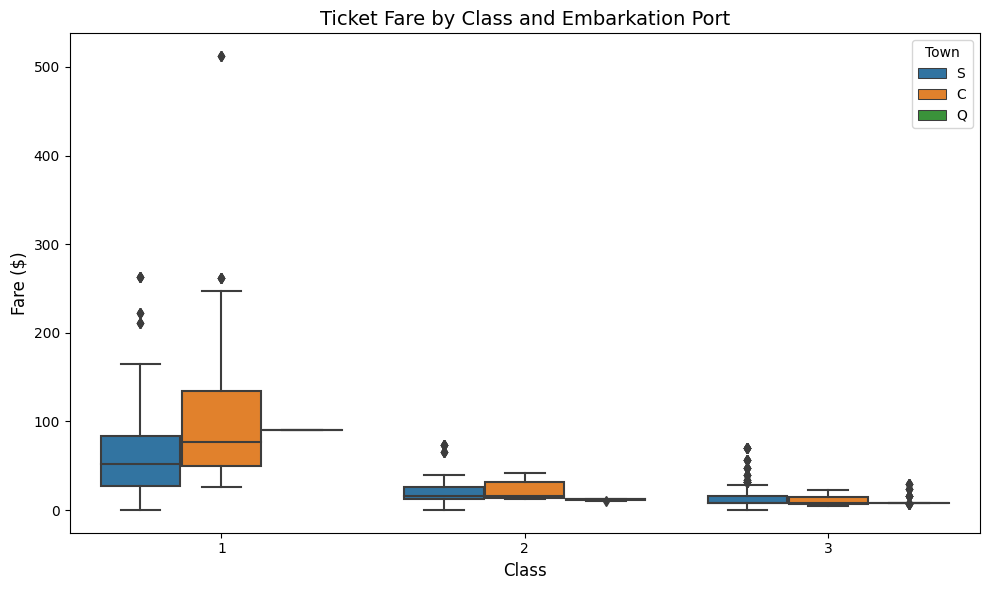

Median for 3rd Class and Southampton: $ 8.05


In [76]:
#Box Plot of Fare, city of emabrkation and class 

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=full_data,
    x="Pclass",          
    y="Fare",           
    hue="Embarked"   
)

# Format
plt.title("Ticket Fare by Class and Embarkation Port", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Fare ($)", fontsize=12)
plt.legend(title="Town")
plt.tight_layout()

#Show graph
plt.show()
median_3rdCl_S = np.median(full_data.loc[(full_data.Embarked == 'S') & (full_data.Pclass == 3) & (full_data.Fare.isna()==0),'Fare'])
median_1rdCl_C = np.median(full_data.loc[(full_data.Embarked == 'C') & (full_data.Pclass == 1) & (full_data.Fare.isna()==0),'Fare'])
print("Median for 3rd Class and Southampton: $", median_3rdCl_S)
full_data.loc[(full_data.Embarked == 'S') & (full_data.Pclass == 3) & (full_data.Fare.isna()==1), 'Fare'] = median_3rdCl_S
full_data.loc[full_data.Embarked.isna(), 'Embarked'] = "C"

 As the passagenger with missing "Fare" embarked in Southampton in the 3rd class it is reasonable to assume that he paid $ 8.05 for the ticket. Notice that there are outliers in data.

 The passengers with "embarked" missing values boarded in the first class and paid  $ 80.0. This tax is closer to the median of the first class passengers which embarked in Cherbourg ( 76.72), so let's assume that they embarked in Cherbourg.

In [11]:
#Replacing null Fare
full_data.loc[full_data.Fare.isna(),'Fare'] = median_3rdCl_S

#Replacing null Embarked
full_data.loc[full_data.Embarked.isna(), "Embarked"] = 'C'


**Ticket type**

The tickets share some common names and initial characters, while others are purely numeric. 

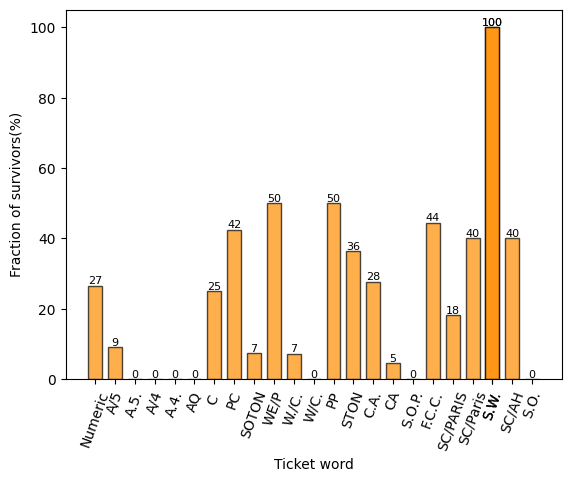

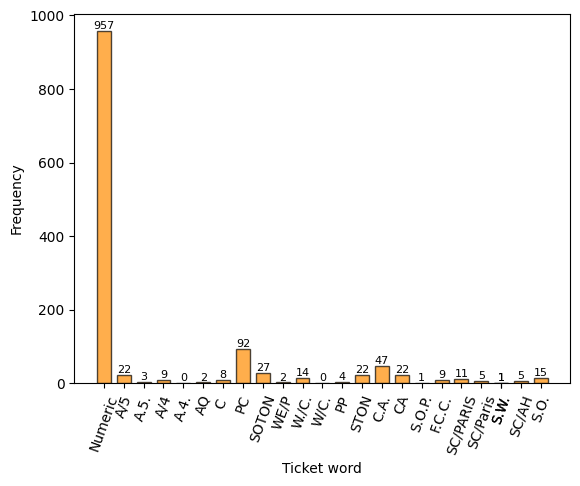

In [78]:
Tickets_analysis(full_data, "", 1, 0)
Tickets_analysis(full_data, "", 1, 1)

I grouped the data based on these characteristics in the 'Ticket_type' column. Ticket types with a count of 20 or fewer were categorized under the 'Other' type.

In [79]:
tickets_str = ['Numeric', 'A', 'AQ', 'C ', 'PC', 'S.O.', 'WE/P', 'W./C.', 'PP', 'STON', 
               'C.A.', 'S.O.P.', 'F.C.C.', 'SC/PARIS', 'S.W.', 'SC/AH', 'SOTON']

for tc in tickets_str:
    if tc == 'Numeric':
        condition = full_data.Ticket.str.match(r'^\d+$', na=False)
        full_data.loc[condition, "Ticket_type"] = tc
    elif tc == 'A':
        condition = full_data.Ticket.str.startswith('A.') | full_data.Ticket.str.startswith('A/')
        lendata = len(full_data.loc[condition])
        full_data.loc[condition, "Ticket_type"] = tc if lendata > 20 else "Other"
    elif tc == 'SC/PARIS':
        condition = (
            full_data.Ticket.str.startswith('SC/PARIS') | 
            full_data.Ticket.str.startswith('SC/Paris') | 
            full_data.Ticket.str.startswith('S.C./PARIS')
        )
        lendata = len(full_data.loc[condition])
        full_data.loc[condition, "Ticket_type"] = tc if lendata > 20 else "Other"
    elif tc == 'C.A.':
        condition = (
            full_data.Ticket.str.startswith('C.A.') | 
            full_data.Ticket.str.startswith('CA.') | 
            full_data.Ticket.str.startswith('CA')
        )
        lendata = len(full_data.loc[condition])
        full_data.loc[condition, "Ticket_type"] = tc if lendata > 20 else "Other"
    elif tc == 'W./C.':
        condition = (
            full_data.Ticket.str.startswith('W./C.') | 
            full_data.Ticket.str.startswith('W/C.')
        )
        lendata = len(full_data.loc[condition])
        full_data.loc[condition, "Ticket_type"] = tc if lendata > 20 else "Other"
    elif tc == 'S.O.':
        condition = (
            full_data.Ticket.str.startswith('S.O.') & 
            ~full_data.Ticket.str.startswith('STON/')
        )
        lendata = len(full_data.loc[condition])
        full_data.loc[condition, "Ticket_type"] = tc if lendata > 20 else "Other"
    else:
        condition = full_data.Ticket.str.startswith(tc)
        lendata = len(full_data.loc[condition])
        full_data.loc[condition, "Ticket_type"] = tc if lendata > 20 else "Other"

full_data.loc[full_data.Ticket_type.isna(), 'Ticket_type'] = "Other"


**Cabin type**

 About 77 % of the "Cabin" values are null values. The remaining 23% can be categorized based on their initial letters.


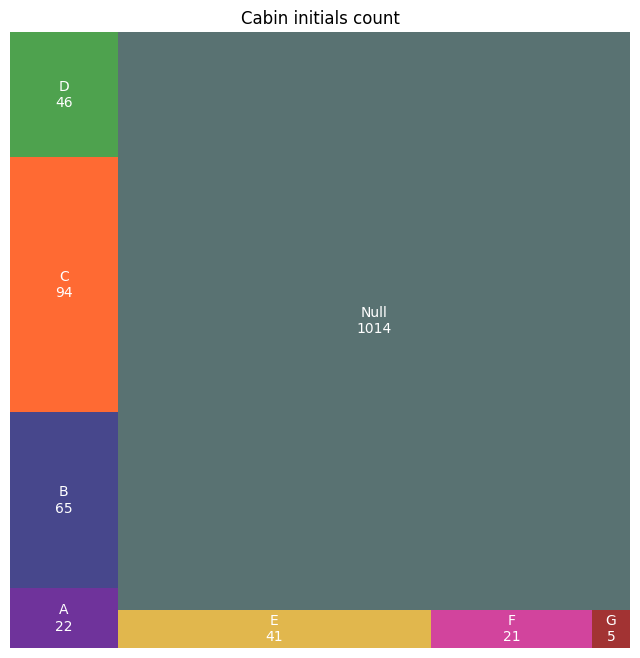

In [80]:
 Cabin_analysis(full_data, "", 1,1)

In [81]:
#Cabin analysis - Saving the cabin initials in the "Cabin_type" column

Cabins_str = ['A','B','C', 'D', 'E','F', 'G']
Cabins_count = []
full_data["Cabin_type"] = "Undefined"
for cb in Cabins_str:    
    full_data.loc[full_data.Cabin.str.startswith(cb, na = False), "Cabin_type"] = cb


**Title**

Another important feature is the title. Here the titles are extracted from the name column and saved in the "Title" column. 

In [82]:
#Creating Title
full_data['Title'] = full_data['Name'].str.replace(r'(.*, )|(\..*)', '', regex=True)

Title = full_data['Title'].unique()
Title_Arr_Surv=[]
Count = []

#Title, Count and survival rate
for tt in range(len(Title)):
    
    Count.append(len(full_data.loc[(full_data.Title == Title[tt])&(full_data.Survived.isna()!=1)]))
    if Count[tt] == 0:
        Title_Arr_Surv.append(0)
    else:
        Title_Arr_Surv.append(100*len(full_data[(full_data.Title == Title[tt])&(full_data.Survived)&(full_data.Survived.isna()!=1)])/Count[tt])

#Making the tabel (df)
Title_table=pd.DataFrame({'Title':Title,
             'Count': Count,
             'Survival rate (%)': Title_Arr_Surv
            })

#print
print(tabulate(round(Title_table,1), headers='keys', tablefmt = 'pretty'))
print("* Statistics from training data")

+----+--------------+-------+-------------------+
|    |    Title     | Count | Survival rate (%) |
+----+--------------+-------+-------------------+
| 0  |      Mr      |  517  |       15.7        |
| 1  |     Mrs      |  125  |       79.2        |
| 2  |     Miss     |  182  |       69.8        |
| 3  |    Master    |  40   |       57.5        |
| 4  |     Don      |   1   |        0.0        |
| 5  |     Rev      |   6   |        0.0        |
| 6  |      Dr      |   7   |       42.9        |
| 7  |     Mme      |   1   |       100.0       |
| 8  |      Ms      |   1   |       100.0       |
| 9  |    Major     |   2   |       50.0        |
| 10 |     Lady     |   1   |       100.0       |
| 11 |     Sir      |   1   |       100.0       |
| 12 |     Mlle     |   2   |       100.0       |
| 13 |     Col      |   2   |       50.0        |
| 14 |     Capt     |   1   |        0.0        |
| 15 | the Countess |   1   |       100.0       |
| 16 |   Jonkheer   |   1   |        0.0        |


 So, if you were a Miss, Mrs, or Master passenger on the Titanic, your chances of survival would have been significantly higher. It's challenging to draw conclusions about titles like Mme, Ms, Lady, Sir, and Mlle due to their low frequency. Titles provide valuable insights into a passenger's social status, which is a relevant factor. Therefore, let's create a new column called 'Status' to classify them accordingly.

In [83]:
#Social Class

full_data['Social_class'] = ""
Title_category = ['Mr', 'Mr_Miss', 'Master', 'Noble', 'Officer', 'Clergy', 'Dr']
Title_members_category = [['Mr'],['Mrs','Miss', 'Mme', 'Mlle', 'Ms'], ['Master'],['Sir', 'Lady', 'the Countess','Don', 'Jonkheer', 'Dona'], ['Major', 'Col', 'Capt'], ['Rev'], ['Dr']]

for i in range(len(Title_category)):
    for j in range(len(Title_members_category[i])):
        full_data.loc[full_data.Title == Title_members_category[i][j], 'Social_class' ] = Title_category[i]
social_count = []
social_surv = []

#Social class count and survival rate
for tc in Title_category:
    social_slice = full_data[(full_data.Social_class == tc) & (full_data.Survived.isna() != 1)]
    social_count.append(len(social_slice))
    social_surv.append( 100*len(social_slice[social_slice.Survived == 1])/len(social_slice))

#Making the table (df)
social_table =pd.DataFrame( {"Social class": Title_category,
               "Count": social_count,
               "Survival rate (%)": social_surv})
#print
print(tabulate(round(social_table,1), headers = 'keys', tablefmt = 'pretty'))
print("* Statistics from training data")

+---+--------------+-------+-------------------+
|   | Social class | Count | Survival rate (%) |
+---+--------------+-------+-------------------+
| 0 |      Mr      |  517  |       15.7        |
| 1 |   Mr_Miss    |  311  |       74.0        |
| 2 |    Master    |  40   |       57.5        |
| 3 |    Noble     |   5   |       60.0        |
| 4 |   Officer    |   5   |       40.0        |
| 5 |    Clergy    |   6   |        0.0        |
| 6 |      Dr      |   7   |       42.9        |
+---+--------------+-------+-------------------+
* Statistics from training data


**Family size**

 The number of parents/children and siblings/spouses can be combined into a single Family Size category, as this is also a factor that influences the probability of survival.

In [84]:
# Creating "Family_size" and "Is_alone" columns

full_data["Family_size"] = full_data["SibSp"] + full_data["Parch"] +1
full_data["Is_alone"] = full_data["Family_size"] == 1

gender_surv = pd.crosstab(full_data.loc[full_data.Survived.isna()!=1, 'Family_size'], full_data.loc[full_data.Survived.isna()!=1, 'Survived'])
gender_surv = gender_surv[[1, 0]]



**Missing values at Age column**

To replace the null values in the 'Age' column the Random Forest model was employed.

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import numpy as np

full_data_backup = full_data.copy()


features = ['Fare', 'Pclass', 'Sex',  'Social_class', 'Embarked', 
             'Ticket_type', 
            'Family_size', 'Is_alone']

# Parameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}


tmp_train_data = full_data.dropna(subset=['Age'])  # Drop rows where 'Age' is NaN
tmp_predict_data = full_data.loc[full_data.Age.isna()]  # Select rows where 'Age' is NaN



X_train = tmp_train_data[features]
Y_train = tmp_train_data['Age']

# Initialize KFold cross-validation
kf = KFold(10, shuffle=True, random_state=10)

# Initialize RandomizedSearchCV for RandomForestRegressor
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist, n_iter=10, cv=kf, n_jobs=-1, verbose=1, random_state=1)

# KFold cross-validation
for i, (train_lines, valid_lines) in enumerate(kf.split(X_train)):
    print(f"[{i}]")
    print(f"Train size: {len(train_lines)}")
    print(f"Valid size: {len(valid_lines)}")
    
    x_train, x_valid = X_train.iloc[train_lines], X_train.iloc[valid_lines]
    y_train, y_valid = Y_train.iloc[train_lines], Y_train.iloc[valid_lines]

    # Transform x_train and x_valid to dummy variables
    x_train = pd.get_dummies(x_train)
    x_valid = pd.get_dummies(x_valid)

    # Align columns between x_train and x_valid
    x_train, x_valid = x_train.align(x_valid, join='left', axis=1, fill_value=0)

   
    random_search.fit(x_train, y_train)

    # Get the best model from RandomizedSearchCV
    best_model = random_search.best_estimator_

   
    predictions = best_model.predict(x_valid)

    #Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_valid, predictions)
    print(f"Mean Absolute Error: {mae}\n")

# Substituting predicted data

X_predict = tmp_predict_data[features]

X_train = pd.get_dummies(X_train)
X_predict = pd.get_dummies(X_predict)

# Align the columns of X_predict with those of X_train
X_predict, _ = X_predict.align(X_train, join='right', axis=1, fill_value=0)

# Ensure that the columns are correctly aligned
assert list(X_train.columns) == list(X_predict.columns), "Columns are not properly aligned!"

#Prediction
predict_ages = best_model.predict(X_predict)

# Replace predicted values in the original DataFrame
full_data.loc[full_data.Age.isna(), 'Age'] = predict_ages




[0]
Train size: 941
Valid size: 105
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mean Absolute Error: 9.528886569302742

[1]
Train size: 941
Valid size: 105
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mean Absolute Error: 9.322288605227962

[2]
Train size: 941
Valid size: 105
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mean Absolute Error: 9.36172018163572

[3]
Train size: 941
Valid size: 105
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mean Absolute Error: 8.645304042787147

[4]
Train size: 941
Valid size: 105
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mean Absolute Error: 9.097976458506716

[5]
Train size: 941
Valid size: 105
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mean Absolute Error: 8.960764070559096

[6]
Train size: 942
Valid size: 104
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Mean Absolute Error: 9.042411606624881

[7]
Train size: 942
Valid si

 After substituing the missing values, the 'Age' distribution looks nice

Before


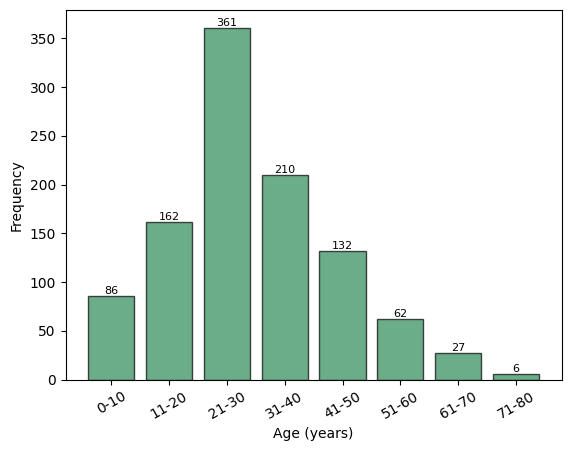

After


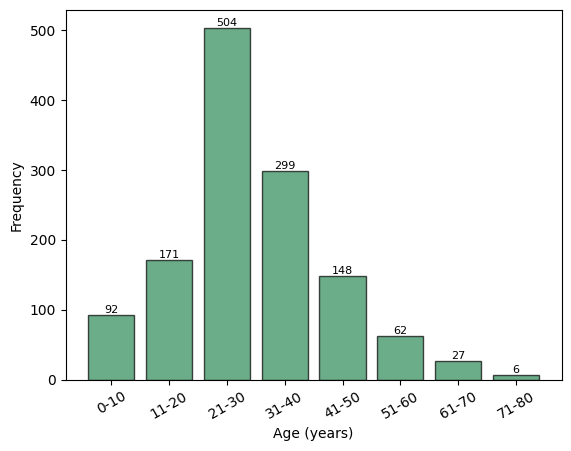

In [86]:
print("Before")
Age_analysis(full_data_backup, "/kaggle/working/TrainData_AgeData", 1,1)
print("After")
Age_analysis(full_data, "/kaggle/working/TrainData_AgeTempData", 1,1)
full_data["Age_is_rare"] = False
full_data.loc[full_data.Age>60, "Age_is_rare"] = True


## DATA MODELING

In [87]:
 # Preparing the data for modeling

train_data = full_data.loc[full_data.Survived.isna() == 0].copy()
test_data = full_data.loc[full_data.Survived.isna() == 1].copy()

test_data.drop('Survived', axis=1, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

 I am currently employing a Random Forest Model, which is yielding an accuracy score of approximately 0.79. This performance can be potentially enhanced through techniques such as resampling the data to further align the distributions between the training and test sets.

[0]
Train size: 712
Valid size: 179
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.8491620111731844

[1]
Train size: 713
Valid size: 178
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.848314606741573

[2]
Train size: 713
Valid size: 178
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.8146067415730337

[3]
Train size: 713
Valid size: 178
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.8314606741573034

[4]
Train size: 713
Valid size: 178
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.8370786516853933

Average accuracy: 0.8361245370660976


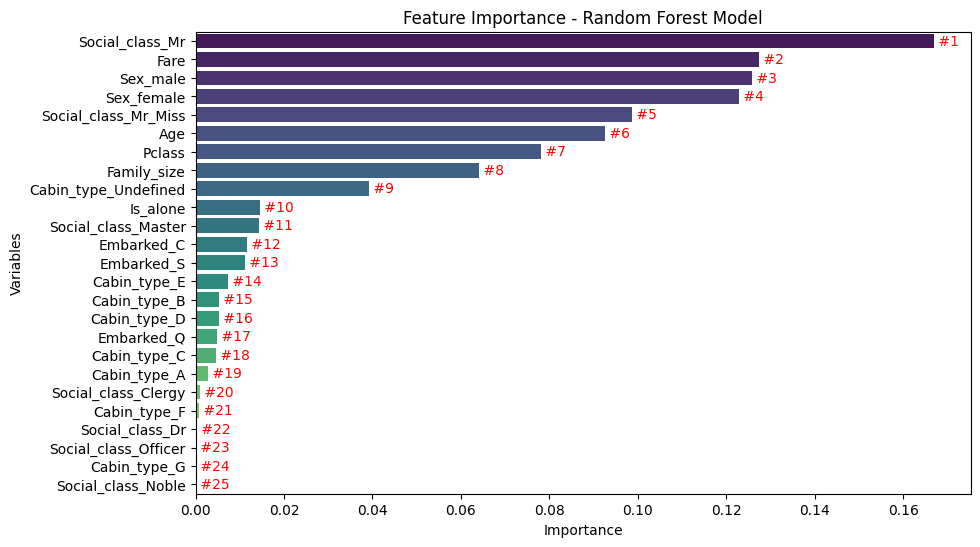

In [88]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score


features = ["Age",  'Fare', "Pclass", "Sex", "Social_class", "Embarked", 
            "Family_size", "Is_alone", "Cabin_type"]
X = train_data[features]
Y = train_data["Survived"]
i = 0



# Parameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

results = []

# StratifiedKFold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Divisão estratificada em 10 folds

best_model = None  

# RandomizedSearchCV initialization
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=1),
                                   param_distributions=param_dist, n_iter=10, cv=kf, 
                                   n_jobs=-1, verbose=1, random_state=42)

#StratifiedKFold cross-validation
for train_lines, valid_lines in kf.split(X, Y):
    print(f"[{i}]")
    print(f"Train size: {train_lines.shape[0]}")
    print(f"Valid size: {valid_lines.shape[0]}")
    
    x_train, x_valid = X.iloc[train_lines], X.iloc[valid_lines]
    y_train, y_valid = Y.iloc[train_lines], Y.iloc[valid_lines]

    # Transform x_train and x_valid to dummy variables
    x_train = pd.get_dummies(x_train)
    x_valid = pd.get_dummies(x_valid)

     # Align columns between x_train and x_valid
    x_train, x_valid = x_train.align(x_valid, join='left', axis=1, fill_value=0)

   
    random_search.fit(x_train, y_train)

    # Get the best model 
    best_model = random_search.best_estimator_

    # Predict using the best model
    p = best_model.predict(x_valid)
    
    #accuracy
    acc = accuracy_score(y_valid, p)
    results.append(acc)
    print(f"Accuracy: {acc}\n")
    
    i += 1

print(f"Average accuracy: {np.mean(results)}")

# Training using the full training data set
X = train_data[features]
Y = train_data["Survived"]


X = pd.get_dummies(X)

# Model with the best parameters
final_model = random_search.best_estimator_


final_model.fit(X, Y)

# Calculating the importance of each parameter
importance = final_model.feature_importances_

# Importance data frame
var_importance = pd.DataFrame({
    'Variables': X.columns,
    'Importance': importance
})

# Ordering by importance
var_importance = var_importance.sort_values(by='Importance', ascending=False)

# Ranking
var_importance['Rank'] = ['#' + str(i + 1) for i in range(len(var_importance))]

# Plot figure
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variables', data=var_importance, palette='viridis')

# Labels
for index, value in enumerate(var_importance['Importance']):
    plt.text(value, index, ' ' + var_importance['Rank'].iloc[index], color='red', va='center')

# Format
plt.title('Feature Importance - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()

# Preparing test data 
X_test = pd.get_dummies(test_data[features])


X_test, _ = X_test.align(x_train, join='left', axis=1, fill_value=0)

# Predictions
predictions = final_model.predict(X_test)

# Output
output = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions.astype(int)  # Garantir que o resultado seja um inteiro
})

output.to_csv('submission.csv', index=False)




 As expected, social class, gender, age and passenger class rank among the most important features. Below are the accuracy evolution curve and the ROC curve. The accuracy stabilizes at values above 0.8, and the ROC curve achieves a value of 0.9, indicating strong performance.

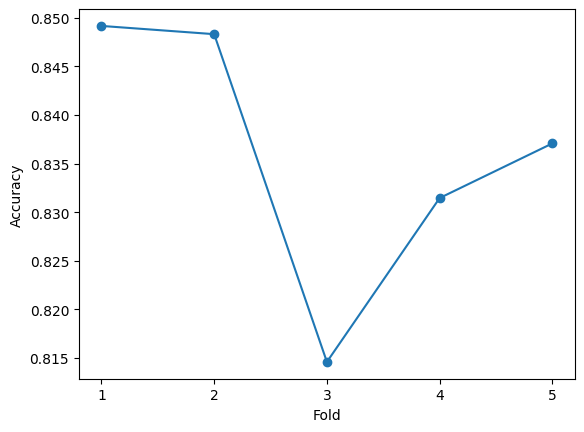

In [89]:
# Accuracy evolution plot
plt.ylabel("Accuracy")
plt.xlabel("Fold")
x = np.arange(len(results))+1
plt.xticks(x)
plot =plt.plot(x, results,"-o")

[0]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fold 0: AUC = 0.8955
[1]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fold 1: AUC = 0.8790
[2]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fold 2: AUC = 0.8467
[3]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fold 3: AUC = 0.8707
[4]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fold 4: AUC = 0.9037


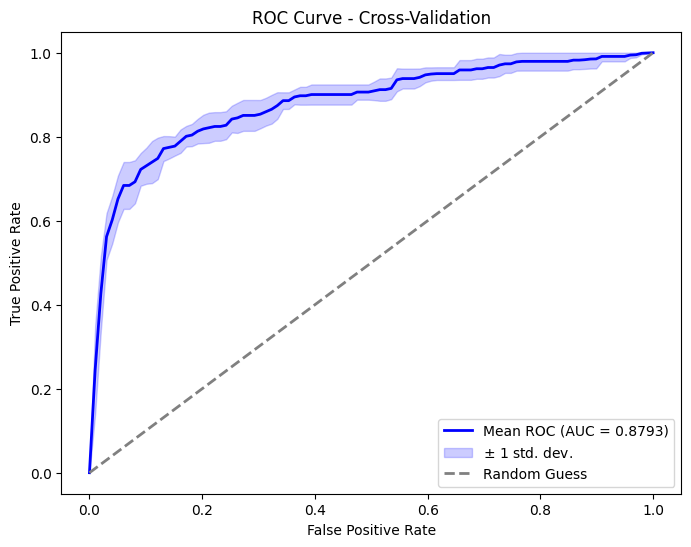

In [91]:
from sklearn.metrics import roc_curve, auc

# List to store ROC curve values for each fold
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train_lines, valid_lines) in enumerate(kf.split(X, Y)):
    print(f"[{i}]")

    x_train, x_valid = X.iloc[train_lines], X.iloc[valid_lines]
    y_train, y_valid = Y.iloc[train_lines], Y.iloc[valid_lines]

    # Convert categorical variables to dummy/indicator variables
    x_train = pd.get_dummies(x_train)
    x_valid = pd.get_dummies(x_valid)

    # Align columns between x_train and x_valid
    x_train, x_valid = x_train.align(x_valid, join='left', axis=1, fill_value=0)

    # Fit the RandomizedSearchCV
    random_search.fit(x_train, y_train)

    # Best model
    best_model = random_search.best_estimator_

    # Get prediction probabilities
    y_proba = best_model.predict_proba(x_valid)[:, 1]

    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpolation for mean ROC curve
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    print(f"Fold {i}: AUC = {roc_auc:.4f}")

# Calculate the mean and confidence interval for the ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.4f})", lw=2)
plt.fill_between(mean_fpr, 
                 np.maximum(mean_tpr - np.std(tprs, axis=0), 0), 
                 np.minimum(mean_tpr + np.std(tprs, axis=0), 1), 
                 color='blue', alpha=0.2, label=r'$\pm$ 1 std. dev.')

# Reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')

plt.title("ROC Curve - Cross-Validation")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
